# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Bayesian Network Deep Dive


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This code contains some in-line quality checking during the processing, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun

### Initialize variables

Based on the project directory, and the site and year you have input, setvars.py will set a bunch of variables as the names of folders, files, and fields. Set-up the project folder and paths: 

In [2]:
from CoastalVarExtractor.setvars import *

extendedTrans = os.path.join(home, 'fiis_trans')
extTrans_tidy = os.path.join(home, 'tidyTrans')

inletLines = os.path.join(home, 'inletLines')
ShorelinePts = os.path.join(home, 'SLpts_utm')
dlPts = os.path.join(home, 'DLpts_utm')
dhPts = os.path.join(home, 'DHpts_utm')
armorLines = os.path.join(home, 'armorLines')
elevGrid = os.path.join(home, 'DEM')
elevGrid_5m = os.path.join(home, 'DEM_5m')
barrierBoundary = os.path.join(home, 'bndpoly_2sl')  
shoreline = os.path.join(home, 'ShoreBetweenInlets')

SubType = os.path.join(home, 'FI12_SubType')
VegType = os.path.join(home, 'FI12_VegType')
VegDens = os.path.join(home, 'FI12_VegDen')
GeoSet = os.path.join(home, 'FI12_GeoSet')

tr_w_anthro = os.path.join(home, 'fiis_trans_wAnthro')

site: FireIsland
year: 2012
setvars.py initialized variables.


## Transect-averaged values
We work with the shapefile/feature class as a Pandas Dataframe as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 

In [5]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Converting feature class to array...
Converting array to dataframe...

Header of transects dataframe (rows 1-5 out of 1102): 


,DD_ID,TRANSECTID,TRANSORDER,sort_ID
sort_ID,,,,
1,10001,NaN,NaN,1
2,10002,NaN,NaN,2
3,10003,NaN,NaN,3
4,10004,NaN,NaN,4
5,10005,NaN,NaN,5


### Add XY and Z/slope from DH, DL, SL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [9]:
# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save as pickle
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))


Joining shoreline points to transects...
...duration at transect 100: 0:1:10.1 seconds
...duration at transect 200: 0:2:19.3 seconds
...duration at transect 300: 0:3:27.5 seconds
...duration at transect 400: 0:4:36.9 seconds
...duration at transect 500: 0:5:43.4 seconds
...duration at transect 600: 0:6:50.1 seconds
...duration at transect 700: 0:7:58.3 seconds
...duration at transect 800: 0:9:6.0 seconds
...duration at transect 900: 0:10:15.2 seconds
...duration at transect 1000: 0:11:22.8 seconds
...duration at transect 1100: 0:12:29.2 seconds
Duration: 0:12:30.5 seconds


'\\\\Mac\\stor\\Projects\\TransectExtraction\\FireIsland2012\\scratch.gdb\\pts2trans_SL'

In [10]:
sl2trans_df.sample(10)

,SL_x,SL_y,Bslope
sort_ID,,,
1046,690682.577152,4.515460e+06,-0.144930
247,653894.002215,4.500176e+06,-0.103252
454,663758.594029,4.503309e+06,-0.097176
490,665411.340539,4.503977e+06,-0.111267
722,675799.174877,4.509154e+06,-0.111831
777,678297.007612,4.510304e+06,-0.083308
687,674234.851811,4.508367e+06,-0.097304
350,658814.555399,4.501697e+06,-0.125256
496,665678.968856,4.504113e+06,-0.112259


#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points 'snapped' to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width.

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. 
2. Get the X, Y, and Z values of the point and the XY position 'snapped' to the transect. The 'snapped' XY position is calculated using the arcpy geometry method. If there are no points within 25 m of the transect, populate the row with Null values; 
3. Convert the elevations to the MHW datum by applying the MHW offset.

In [ ]:
# Create dataframe for both dune crest and dune toe positions
dune2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, dlPts, trans_df, 
                                          tID_fld, proximity=pt2trans_disttolerance)

# Save
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans.pkl'))

#### Armoring
__Arm_x__, __Arm_y__, and __Arm_zMHW__ are the easting, northing, and height above MHW, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 
4. Convert the elevations to the MHW datum by applying the MHW offset.

In [12]:
# Armoring line
arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid_5m)

# Save
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

Converting feature class to array with X and Y...
Converting array to dataframe...


### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [13]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dune2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

# Display
trans_df.sample(10)

,DD_ID,TRANSECTID,TRANSORDER,SL_x,SL_y,Bslope,DH_x,DH_y,DH_z,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_z,Arm_x,Arm_y
sort_ID,,,,,,,,,,,,,,,,,,,
724,10724,1684.0,1684.0,675893.184445,4.509189e+06,-0.093384,675846.2618,4.509282e+06,3.037682,675849.981315,4.509283e+06,675855.5390,4.509260e+06,2.224211,675859.852910,4.509262e+06,NaN,NaN,NaN
370,10370,1330.0,1330.0,659765.650997,4.502006e+06,-0.117890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,10260,1220.0,1220.0,654508.601386,4.500388e+06,-0.076279,654495.6339,4.500478e+06,3.882869,654481.400608,4.500473e+06,654498.2041,4.500469e+06,2.959294,654484.073471,4.500465e+06,NaN,NaN,NaN
526,10526,1486.0,1486.0,667063.757974,4.504691e+06,-0.132031,667017.8042,4.504794e+06,6.032128,667017.012575,4.504794e+06,667028.0579,4.504770e+06,3.314023,667027.923287,4.504770e+06,NaN,NaN,NaN
851,10851,1811.0,1811.0,681682.718504,4.511797e+06,-0.112929,681631.7822,4.511878e+06,5.920834,681643.526283,4.511883e+06,681634.2235,4.511872e+06,3.968426,681646.124079,4.511877e+06,NaN,NaN,NaN
1049,11049,2004.0,2004.0,690817.516389,4.515527e+06,-0.104270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,11010,1970.0,1970.0,689054.978559,4.514792e+06,-0.094953,689006.6684,4.514901e+06,7.431038,689005.408544,4.514901e+06,689015.9457,4.514879e+06,5.364113,689015.280196,4.514879e+06,NaN,NaN,NaN
273,10273,1233.0,1233.0,655126.599920,4.500590e+06,-0.084145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,10295,1255.0,1255.0,656191.733279,4.500871e+06,-0.113099,656161.0700,4.500948e+06,6.670766,656166.475355,4.500949e+06,656163.6401,4.500939e+06,3.838080,656169.148237,4.500941e+06,NaN,NaN,NaN


### Check for errors: display summary stats / histograms and create feature classes
*Optional*

The feature classes will display the locations that will be used to calculate beach width. Output files for validation:

- pts2trans_SL
- ptSnap2trans_DL
- ptSnap2trans_DH
- arm2trans

              DD_ID   TRANSECTID   TRANSORDER           SL_x          SL_y  \
count   1102.000000  1066.000000  1066.000000    1059.000000  1.059000e+03   
mean   10551.500000  2054.979362  1523.388368  667074.770444  4.505626e+06   
std      318.264303   933.920785   308.253148   14187.003803  5.636001e+03   
min    10001.000000  1189.000000   990.000000  642121.033284  4.498010e+06   
50%    10551.500000  1721.500000  1523.500000  667348.552153  4.504790e+06   
max    11102.000000  4049.000000  2057.000000  691774.089125  4.515827e+06   

            Bslope          DH_x          DH_y        DH_z       DH_snapX  \
count  1068.000000     819.00000  8.190000e+02  819.000000     819.000000   
mean     -0.096666  669894.99336  4.506937e+06    5.051482  669895.360056   
std       0.034450   15092.21316  6.020121e+03    1.672000   15092.801199   
min      -0.162160  642901.54630  4.498103e+06    1.101953  642904.906236   
50%      -0.102240  672274.81970  4.507484e+06    5.221629  672274.5

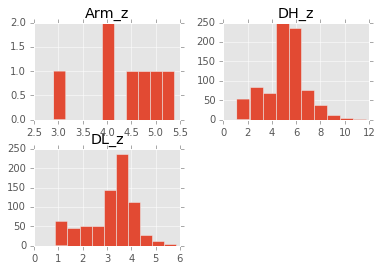

In [17]:
print(trans_df.describe([]))

trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])
plt.show()
plt.close()

In [18]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
except Exception as err:
    print(err)
    pass

In [3]:
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_x__, __DL_y__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
1. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_x__, __DL_y__ and __DH_x__, __DH_y__)
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zMHW__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zMHW__) to __uBW__ and __uBH__, respectively. 

In [4]:
#%% Calculate distances from shore to dunes, etc.
trans_df  = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, MHW, fill)

#### Spot-check the beach width values.

count    755.000000
mean      77.290516
std       26.004743
min       10.156794
25%       64.478313
50%       79.545289
75%       87.015093
max      449.594338
Name: uBW, dtype: float64


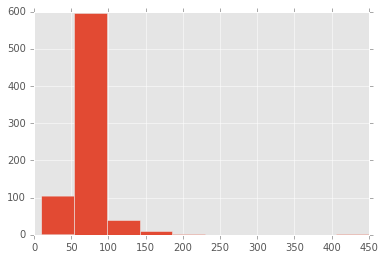

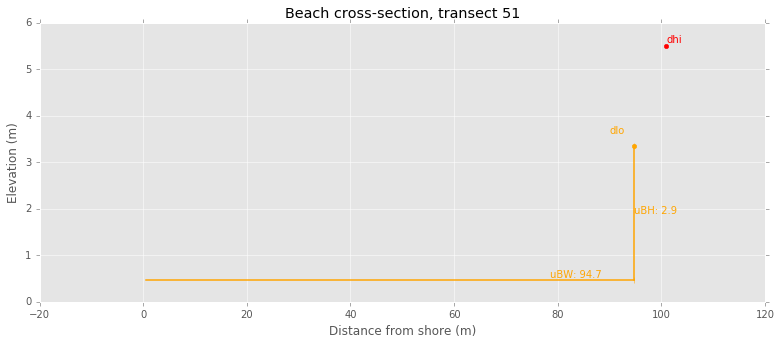

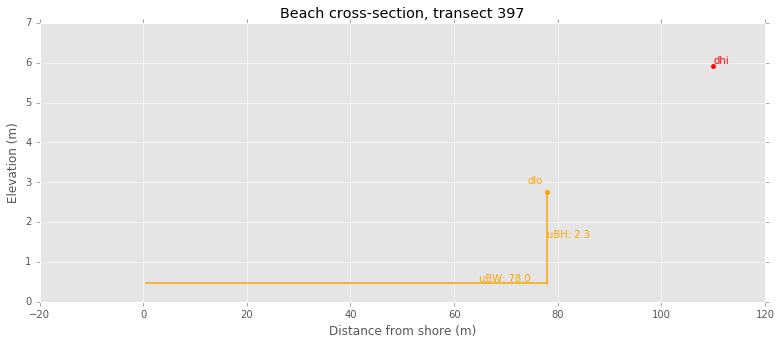

In [6]:
# View distribution of uBW values as descriptive stats and histogram.
fld = 'uBW'
print(trans_df[fld].describe())
trans_df[fld].hist()
plt.show()
plt.close('all')

# Randomly sample 5 rows
ran_samp = trans_df.sample(5)
ran_samp.loc[:,['SL_x', 'SL_y', 'DistDL', 'DL_zmhw', 'DistDH', 'DH_zmhw', 'DistArm', 'Arm_zmhw', 'uBW', 'uBH']]

# For one row, plot the dlo, dhi position with uBW and uBH
tran = ran_samp.iloc[0]

# Beach detail
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Beach cross-section, transect {}'.format(tran.name))

# Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='orange')
plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
plt.scatter(tran.DistDH, tran.DH_z, color='red')
plt.annotate('dhi', xy=(tran.DistDH-0.02, tran.DH_z+0.08), color='red')
plt.scatter(tran.DistArm, tran.Arm_z, color='black')
plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

# Upper beach width and height
uBW = tran.uBW
uBH = tran.uBH
plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+0.03, MHW+uBH*0.5), color='orange')

plt.show()


# For one row, plot the dlo, dhi position with uBW and uBH
tran = ran_samp.iloc[1]

# Beach detail
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Beach cross-section, transect {}'.format(tran.name))

# Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='orange')
plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
plt.scatter(tran.DistDH, tran.DH_z, color='red')
plt.annotate('dhi', xy=(tran.DistDH-0.02, tran.DH_z+0.08), color='red')
plt.scatter(tran.DistArm, tran.Arm_z, color='black')
plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

# Upper beach width and height
uBW = tran.uBW
uBH = tran.uBH
plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+0.03, MHW+uBH*0.5), color='orange')



plt.show()
plt.close('all')

### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [7]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Save
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

C:\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\numpy\lib\nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


Duration: 0:0:10.8 seconds


In [33]:
dist_df.tail(10)

,Dist2Inlet
sort_ID,
1060.0,1237.057385
1061.0,1287.485638
1062.0,1337.510599
1063.0,1387.517126
1064.0,1437.542809
1065.0,1487.561412
1066.0,1537.573422
1067.0,1587.588272
1068.0,1637.590818


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

Temporary layers (assuming default names):

- clip2island
- clip2islandSingle_temp'

In [8]:
# Clip transects, get barrier widths *SPATIAL*
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

Getting the width along each transect of the oceanside land (WidthPart)...
Converting feature class to array...
Converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
Converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


In [ ]:
trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])

# Join anthro fields to trans and points DFs
trans_df = fun.join_columns(trans_df, trans_df2) 
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# Save dataframes to open elsewhere or later
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'_anthro.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, transPts_null+'_anthro.pkl'))

## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

It is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed witha Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Temporary files: 
- tran5mPts_unsorted

In [9]:
# if os.path.exists(os.path.join(scratch_dir, transPts_null+'.pkl')):
#     pts_df = pd.read_pickle(os.path.join(scratch_dir,transPts_null+'.pkl'))
#     trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

pts_df, transPts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, 
                                                   fc_out=transPts_presort) # 5 minutes for FireIsland

Getting points every 5m along each transect and saving in both dataframe and feature class...
Converting new dataframe to feature class...
Duration: 0:4:59.0 seconds


### Add Elevation and Slope to points

__ptZmhw__ and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe

In [10]:
# Create elevation and slope rasters at 5-m resolution
if not arcpy.Exists(elevGrid_5m):
    fwa.ProcessDEM(elevGrid, elevGrid_5m, utmSR)
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid_5m, slopeGrid, 'PERCENT_RISE')
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(transPts_presort, 
                                    [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp']])

<geoprocessing server result object at 0xcbda990>

In [15]:
# Add substrate type, geomorphic setting, veg type, veg density values at points.
arcpy.sa.ExtractMultiValuesToPoints(transPts_presort, [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp'],
                                                       [SubType, 'SubType'], [VegType, 'VegType'], 
                                                       [VegDens, 'VegDens'], [GeoSet, 'GeoSet']])

# Convert to dataframe
pts_df = fwa.FCtoDF(transPts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                         'VegType', 'VegDens', 'GeoSet'])

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))

# View 10 randomly selected rows 
pts_df.sample(10)

Converting feature class to array with X and Y...
Converting array to dataframe...


             GeoSet        SHAPE@X       SHAPE@Y       SubType       VegDens  \
count  93934.000000   94079.000000  9.407900e+04  93934.000000  93934.000000   
mean      28.346264  666782.316136  4.505854e+06   7123.509549   2357.158771   
std      489.659160   14698.558230  5.826264e+03   2244.561182   3574.944222   
min        1.000000  642115.635200  4.498010e+06   3333.000000    111.000000   
50%        5.000000  668419.751200  4.505482e+06   7777.000000    666.000000   
max     9999.000000  691774.089100  4.516549e+06   9999.000000   9999.000000   

            VegType         ptSlp           ptZ       sort_ID  
count  93934.000000  89878.000000  92497.000000  94079.000000  
mean    1854.141844      4.119927      1.770002    528.365778  
std     3805.910303      5.004542      1.448397    318.347174  
min       11.000000      0.003688     -0.331833      1.000000  
50%       77.000000      2.360363      1.332160    557.000000  
max     9999.000000     62.704655     12.173281   1069.

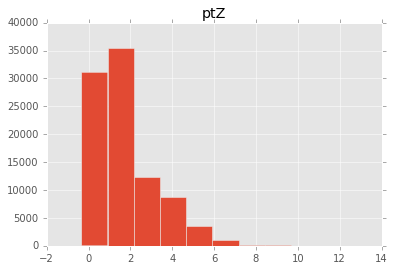

In [18]:
# Convert to dataframe
# pts_df = fwa.FCtoDF(transPts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Save
# pts_df.to_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))

# pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))
print(pts_df.describe([]))

pts_df.hist('ptZ')
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [150]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, '20171219', 'pts_extractedvalues_presort.pkl'))

# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, MHW, fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, MHW, tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes to open elsewhere or later
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))

# View 10 randomly selected rows 
pts_df.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
93955,93955,691720.4091,4.515962e+06,145.000095,623.580950,44.145934,NaN,NaN,2.12988,8.484489,...,768.581045,768.581045,NaN,NaN,NaN,0.439722,4.22028,111.0,222.0,222.0
39392,39392,662220.0580,4.503031e+06,245.000045,80.359401,146.551900,155.293975,NaN,2.05756,5.507650,...,325.359446,325.359446,89.772138,3.325500,DL,1.352224,4.61248,111.0,111.0,222.0
14668,14668,649287.7542,4.499013e+06,250.000068,356.341016,97.092182,165.836620,NaN,4.41872,0.236995,...,606.341083,606.341083,84.170923,3.324845,DL,2.658119,5.32068,111.0,222.0,222.0
78209,78209,683836.4155,4.512979e+06,224.999952,132.127112,117.576724,123.826660,NaN,1.21996,5.248185,...,357.127063,357.127063,101.210953,3.098692,DL,0.965944,4.56292,111.0,111.0,222.0
83736,83736,686446.3000,4.514726e+06,794.999954,94.443074,724.016262,735.263761,NaN,0.31248,0.224057,...,889.443028,889.443028,59.752169,3.672534,DL,0.307085,6.39660,111.0,111.0,222.0


### Recode the values for CSV output and model running

In [151]:
# Recode
pts_df4csv = pts_df.replace({'GeoSet': {9999:-99999},
                             'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}', 9999:-99999}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}', 9999:-99999},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}', 9999:-99999}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save as pickle
pts_df4csv.to_pickle(os.path.join(scratch_dir, transPts_null+'_4csv.pkl'))

# Take a look at some rows
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
77845,77845,683682.4600,4.512714e+06,34.999939,286.238967,65.941869,57.216469,-99999.0,1.37192,0.202823,...,321.238906,321.238906,92.136229,3.384600,DL,1.284051,4.492800,111.0,111.0,222.0
62775,62775,675676.5127,4.509422e+06,295.000024,306.656590,176.117114,203.191263,-99999.0,1.49816,2.683301,...,601.656614,601.656614,91.890089,1.924106,DL,0.877292,2.838120,111.0,111.0,222.0
33390,33390,658158.3139,4.501779e+06,280.000043,286.000343,-99999.000000,-99999.000000,-99999.0,0.95780,1.947103,...,566.000386,566.000386,-99999.000000,-99999.000000,-99999,1.169480,4.301440,111.0,333.0,222.0
69475,69475,678446.4569,4.510699e+06,309.999990,348.247184,214.056554,255.391819,-99999.0,1.19128,1.582451,...,658.247174,658.247174,55.007402,0.717769,DL,0.437211,1.489120,111.0,111.0,222.0
8944,8944,646269.7227,4.498275e+06,85.000036,315.179807,32.997243,15.046744,-99999.0,3.86484,13.857514,...,400.179843,400.179843,96.089641,4.255232,DL,2.527977,7.898001,111.0,333.0,222.0


In [20]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))
pts_df.sample(10)

,SplitSort,GeoSet,seg_x,seg_y,SubType,VegDens,VegType,ptSlp,ptZ,sort_ID,...,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart,mean_Zmhw,max_Zmhw
86801,86801,2.0,687800.1946,4.514290e+06,7777.0,666.0,77.0,1.571020,1.410040,983,...,NaN,120.330082,2.798278,DL,1781.099602,453.350038,453.350038,453.350038,1.918694,4.94544
33938,33938,5.0,658346.2418,4.502011e+06,9999.0,888.0,99.0,1.726788,0.573955,343,...,NaN,88.693154,2.896091,DL,NaN,459.945757,459.945757,459.945757,1.285552,4.54275
67131,67131,4.0,677375.4423,4.510155e+06,7777.0,666.0,77.0,2.361084,0.785800,759,...,NaN,54.157710,1.157022,DL,428.995109,302.779280,302.779280,302.779280,1.148265,2.19412
81726,81726,6.0,686126.9384,4.513982e+06,3333.0,9999.0,9999.0,0.353268,0.502440,950,...,NaN,40.534630,0.949332,DL,NaN,666.626374,666.626374,666.626374,0.250460,1.60496
48099,48099,2.0,669247.7959,4.505807e+06,7777.0,666.0,77.0,2.735332,0.889640,575,...,NaN,NaN,NaN,NaN,NaN,373.567535,373.567535,373.567535,0.899711,2.48492
82858,82858,1.0,686159.6598,4.514752e+06,4444.0,111.0,11.0,2.991067,0.004560,957,...,NaN,57.883583,3.302143,DL,NaN,925.874459,872.059789,758.060338,0.178559,5.03952
16636,16636,5.0,650143.3415,4.499293e+06,6666.0,555.0,55.0,5.602651,4.060840,170,...,NaN,89.785658,1.659205,DL,NaN,416.423025,416.423025,416.423025,1.556313,3.77124
17948,17948,5.0,650881.0923,4.499445e+06,6666.0,555.0,55.0,3.206507,1.301520,185,...,NaN,NaN,NaN,NaN,NaN,468.915783,468.915783,468.915783,0.995525,2.95532
81372,81372,6.0,685775.3600,4.514390e+06,3333.0,9999.0,9999.0,1.750914,0.401120,947,...,NaN,39.701587,1.035483,DL,NaN,762.933189,762.933189,762.933189,0.138418,1.67400
86295,86295,2.0,687597.8354,4.514252e+06,7777.0,666.0,77.0,2.045338,0.825280,979,...,NaN,136.380469,3.414888,DL,1990.533667,714.669235,631.101879,324.093777,0.877693,5.17612


## Quality checking
Look at extracted profiles from around the island. Entered the transect ID within the available range when prompted. Evaluated the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality.

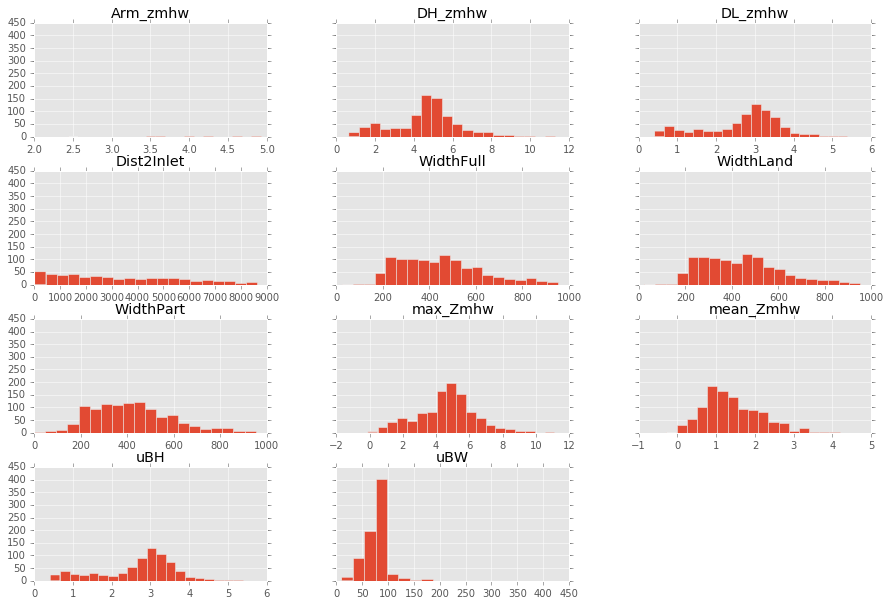

In [23]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']
# trans_df.loc[:,desccols].describe()

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

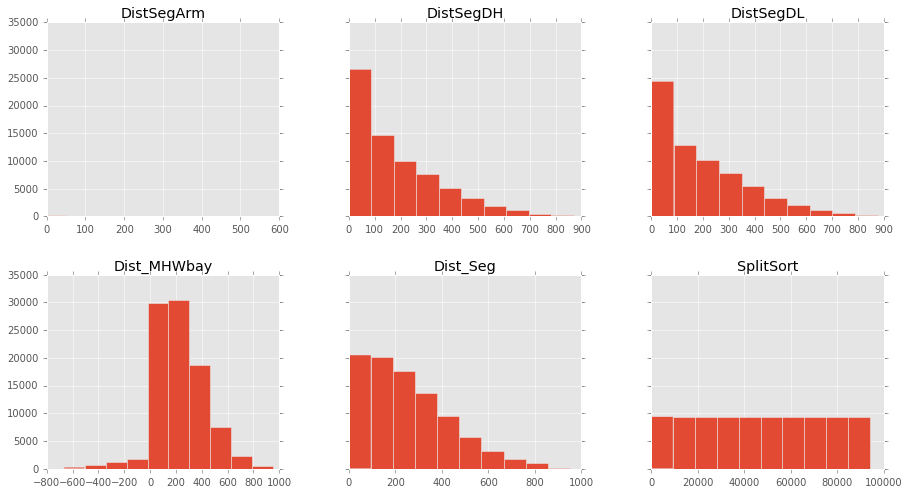

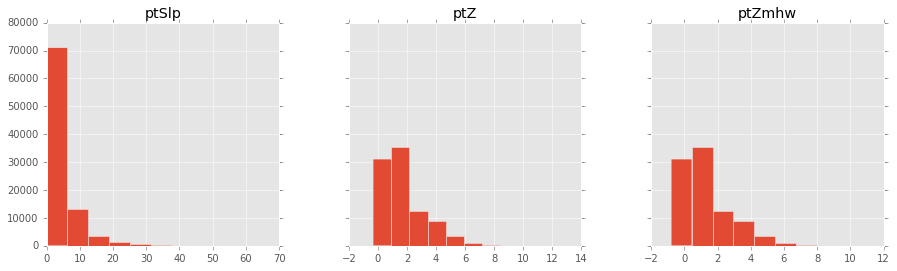

In [24]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))
plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-1102): 919


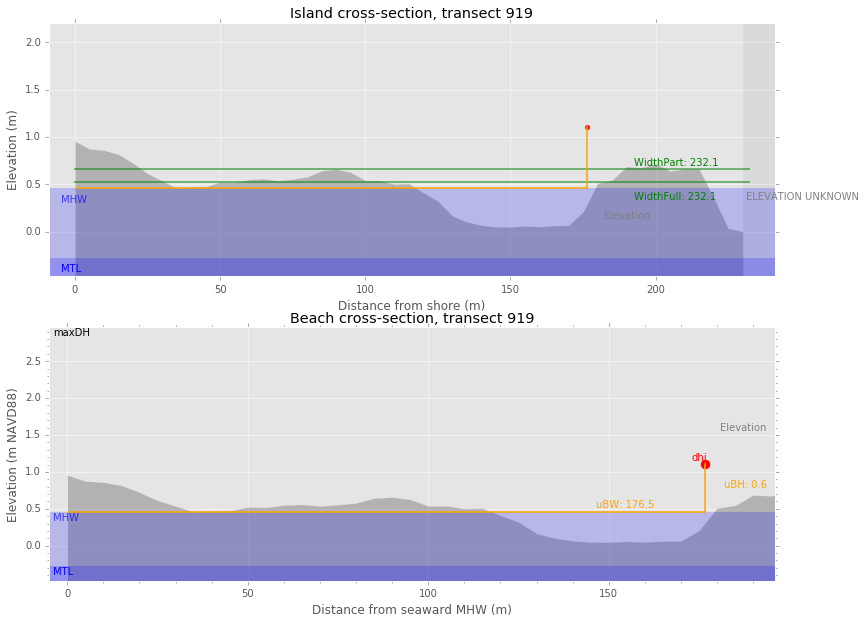

In [61]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
fun.plot_island_profile(ax1, pts_set, MHW, MTL)

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
fun.plot_beach_profile(ax2, pts_set, MHW, MTL, maxDH)

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
#### Vector format

In [3]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_anthro.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'_anthro.pkl'))

In [4]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=extTrans_fill)

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=extTrans_null, out_dir=home)

# Save final transect SHP with fill values
arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, extTrans_shp+'.shp')

OUTPUT: FireIsland2012_extTrans_null


<Result '\\\\Mac\\stor\\Projects\\TransectExtraction\\FireIsland2012\\scratch\\FireIsland2012_extTrans_shp.shp'>

#### Raster - beach width

In [33]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transIDpath):
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transIDpath))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, rst_transID, bw_rst, fill, tID_fld, 'uBW')

OUTPUT: fi12_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

#### Tabular format

Save final pts with fill values as CSV

In [6]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, transPts_fill +'.csv')
pts_df4csv.to_csv(os.path.join(scratch_dir, transPts_fill +'.csv'), na_rep=fill, index=False)
print("OUTPUT: {}".format(csv_fname))

try:
    xls_fname = os.path.join(scratch_dir, transPts_fill +'.xlsx')
    pts_df4csv.to_excel(xls_fname, na_rep=fill, index=False)
    print("OUTPUT: {}".format(xls_fname))
except:
    print("No Excel file created. You'll have to do it yourself from the CSV.")

OUTPUT: \\Mac\stor\Projects\TransectExtraction\FireIsland2012\scratch\FireIsland2012_transPts_fill.csv
No Excel file created. You'll have to do it yourself from the CSV.


#### Vector format

In [7]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, transPts_fill), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=transPts_null, out_dir=home)

# Save final points as SHP and XLS with fill values
arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, transPts_shp+'.shp')

Converting points DF to FC...
OUTPUT: \\Mac\stor\Projects\TransectExtraction\FireIsland2012\FireIsland2012.gdb\FireIsland2012_transPts_fill
Duration: 0:8:12.7 seconds
OUTPUT: FireIsland2012_transPts_null


<Result '\\\\Mac\\stor\\Projects\\TransectExtraction\\FireIsland2012\\scratch\\FireIsland2012_transPts_shp.shp'>

In [95]:
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'_4csv.pkl'))

In [97]:
sorted_pt_flds = ['SplitSort', 'seg_x', 'seg_y',
    'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm',
    'ptZ', 'ptSlp', 'ptZmhw',
    'GeoSet', 'SubType', 'VegDens', 'VegType',
    'sort_ID','TRANSORDER', 'TRANSECTID', 'DD_ID',
    'LRR', 'SL_x', 'SL_y', 'Bslope',
    'DL_x', 'DL_y', 'DL_z', 'DL_zmhw', 'DL_snapX','DL_snapY',
    'DH_x', 'DH_y', 'DH_z', 'DH_zmhw', 'DH_snapX','DH_snapY',
    'Arm_x', 'Arm_y', 'Arm_z', 'Arm_zmhw',
    'DistDH', 'DistDL', 'DistArm',
    'Dist2Inlet', 'WidthPart', 'WidthLand', 'WidthFull',
    'uBW', 'uBH', 'ub_feat', 'mean_Zmhw', 'max_Zmhw',
    'Construction', 'Development', 'Nourishment']

### Report values for Entity and Attribute Information 

In [153]:
for fld in pts_df4csv.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in pts_df4csv.loc[:,fld].unique())))
    else:
        if not any(pd.isnull(pts_df4csv.loc[:,fld])):
            mn = min(pts_df4csv.loc[:,fld])
        else:
            mn = -99999
        mx = np.max(pts_df4csv.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

SplitSort min|max: 0  |  94112
seg_x min|max: -99999.0  |  691774.0891000004
seg_y min|max: -99999.0  |  4516548.8192
Dist_Seg min|max: -99999.0  |  950.0000678282756
Dist_MHWbay min|max: -99999.0  |  952.4071247616973
DistSegDH min|max: -99999.0  |  870.0003850179726
DistSegDL min|max: -99999.0  |  876.2487858152954
DistSegArm min|max: -99999.0  |  509.7874047127337
ptZ min|max: -99999.0  |  12.173280715942383
ptSlp min|max: -99999.0  |  62.704654693603516
ptZmhw min|max: -99999.0  |  11.71328067779541
GeoSet values: 1.0  |  2.0  |  3.0  |  4.0  |  5.0  |  -99999.0  |  6.0
SubType values: 4444.0  |  {1111, 2222}  |  -99999  |  6666.0  |  3333.0
VegDens values: 111.0  |  {111, 222}  |  {333, 444}  |  -99999  |  555.0
VegType values: 11.0  |  {11, 22}  |  {33, 44}  |  {22, 33}  |  -99999  |  55.0
sort_ID min|max: 1.0  |  1102.0
TRANSORDER min|max: -99999.0  |  2057.0
TRANSECTID min|max: -99999.0  |  4049.0
DD_ID min|max: 10001  |  11102
LRR min|max: -99999.0  |  -99999.0
SL_x min|max: -